## A study of the NATICUSdroid dataset

*By Augustin GRUNEWALD & Nils FALCOZ*

We invite you to see the introduction comments about the dataset in the ReadME.


## Loading modules and the dataset

In [11]:
# Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 

In [3]:
# Dataset
original_df = pd.read_csv("data/data.csv", delimiter=",")

## Exploring the dataset

In [4]:
# Basic information (shape, ...)
print(f"Dataset shape : {original_df.shape}")
print(f"Number features : {original_df.shape[1]}")
print(f"Number sample : {original_df.shape[0]}")
original_df.info()

Dataset shape : (29332, 87)
Number features : 87
Number sample : 29332
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29332 entries, 0 to 29331
Data columns (total 87 columns):
 #   Column                                                                         Non-Null Count  Dtype
---  ------                                                                         --------------  -----
 0   android.permission.GET_ACCOUNTS                                                29332 non-null  int64
 1   com.sonyericsson.home.permission.BROADCAST_BADGE                               29332 non-null  int64
 2   android.permission.READ_PROFILE                                                29332 non-null  int64
 3   android.permission.MANAGE_ACCOUNTS                                             29332 non-null  int64
 4   android.permission.WRITE_SYNC_SETTINGS                                         29332 non-null  int64
 5   android.permission.READ_EXTERNAL_STORAGE                                 

In [5]:
# Showing a bit of the dataset
original_df.head()

,android.permission.GET_ACCOUNTS,com.sonyericsson.home.permission.BROADCAST_BADGE,android.permission.READ_PROFILE,android.permission.MANAGE_ACCOUNTS,android.permission.WRITE_SYNC_SETTINGS,android.permission.READ_EXTERNAL_STORAGE,android.permission.RECEIVE_SMS,com.android.launcher.permission.READ_SETTINGS,android.permission.WRITE_SETTINGS,com.google.android.providers.gsf.permission.READ_GSERVICES,...,com.android.launcher.permission.UNINSTALL_SHORTCUT,com.sec.android.iap.permission.BILLING,com.htc.launcher.permission.UPDATE_SHORTCUT,com.sec.android.provider.badge.permission.WRITE,android.permission.ACCESS_NETWORK_STATE,com.google.android.finsky.permission.BIND_GET_INSTALL_REFERRER_SERVICE,com.huawei.android.launcher.permission.READ_SETTINGS,android.permission.READ_SMS,android.permission.PROCESS_INCOMING_CALLS,Result
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [6]:
# Checking for missing values - should find non missing values
print(f"All values are non missing : {np.all(original_df.isna() == False)}")

# Checking the nature of data - all values should be int64
print(f"All values are int64 : {np.all(original_df.dtypes == np.int64)}")

# Checking that all values are 0 or 1 - adding two df of booleans with method .add
print(f"All values are 0 or 1 : {np.all((original_df == 0).add(original_df == 1))}")

All values are non missing : True
All values are int64 : True
All values are 0 or 1 : True


In [7]:
# Checking the number of benign (result = 0) and malware (result = 1) apps
benign_df = original_df[original_df["Result"] == 0]
malware_df = original_df[original_df["Result"] == 1]
print(f"Benign data shape : {benign_df.shape}")
print(f"Malware data shape : {malware_df.shape}")

Benign data shape : (14632, 87)
Malware data shape : (14700, 87)


In [8]:
# Looking only at the native permission requests - starting with keyword android.permission or com.android
native_columns = np.array([[i, label] for i, label in enumerate(original_df.columns) if ("android.permission" in label) or ("com.android" in label)])
non_native_columns = np.array([[i, label] for i, label in enumerate(original_df.columns) if ("android.permission" not in label) and ("com.android" not in label)])

native_permissions_df = (original_df.copy()).drop(list(non_native_columns[:,1]), axis=1)

print(f"Native permission requests dataset shape : {native_permissions_df.shape}")
print(f"Naticus (native + custom) permission requests dataset shape : {original_df.shape}")

Native permission requests dataset shape : (29332, 64)
Naticus (native + custom) permission requests dataset shape : (29332, 87)


## Searching for important features - PCA 

Index(['android.permission.READ_PHONE_STATE', 'Result',
       'android.permission.ACCESS_COARSE_LOCATION',
       'android.permission.ACCESS_FINE_LOCATION',
       'android.permission.RECEIVE_BOOT_COMPLETED'],
      dtype='object')
Index(['android.permission.ACCESS_COARSE_LOCATION',
       'android.permission.ACCESS_FINE_LOCATION',
       'android.permission.READ_PHONE_STATE',
       'android.permission.RECEIVE_BOOT_COMPLETED',
       'android.permission.WRITE_EXTERNAL_STORAGE'],
      dtype='object')


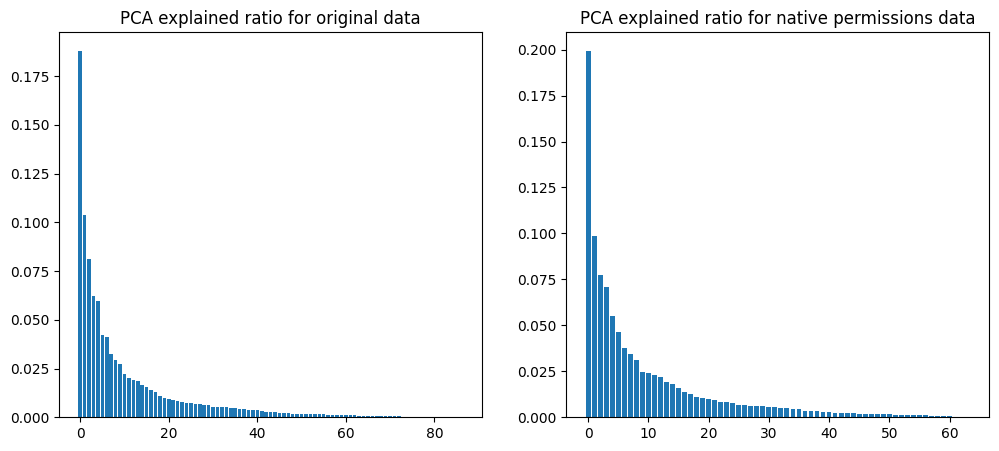

In [42]:
from sklearn.decomposition import PCA

# Computing PCA
pca_original = PCA()
pca_original.fit(original_df)

pca_native = PCA()
pca_native.fit(native_permissions_df)

# Showing the 5 most important permissions for the first PCA vector
first_component_normalized = np.abs(pca_original.components_[0])
max_importance_features = np.arange(original_df.shape[1])[np.argsort(first_component_normalized)[::-1][:5]]
print(original_df.columns[max_importance_features])

first_component_normalized_native = np.abs(pca_native.components_[0])
max_importance_features = np.arange(native_permissions_df.shape[1])[np.argsort(first_component_normalized_native)[::-1][:5]]
print(native_permissions_df.columns[max_importance_features])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes.flatten()

axes[0].bar(range(original_df.shape[1]), pca_original.explained_variance_ratio_)
axes[0].set_title("PCA explained ratio for original data")

axes[1].bar(range(native_permissions_df.shape[1]), pca_native.explained_variance_ratio_)
axes[1].set_title("PCA explained ratio for native permissions data");

In each cases (only native permissions on one side, and all permissions on the other side), we don't observe really important features, only one with about 20% of explained variance ratio and some other with about 10%. This doesn't shows a clear trend, however using the composition of the first vectors of the PCA, we can have a look at the permissions requests with most impact. => non c'est faux mdr

android.permission.GET_ACCOUNTS                                            6630
com.sonyericsson.home.permission.BROADCAST_BADGE                           1005
android.permission.READ_PROFILE                                            1346
android.permission.MANAGE_ACCOUNTS                                          399
android.permission.WRITE_SYNC_SETTINGS                                      169
                                                                          ...  
com.google.android.finsky.permission.BIND_GET_INSTALL_REFERRER_SERVICE      696
com.huawei.android.launcher.permission.READ_SETTINGS                        686
android.permission.READ_SMS                                                1517
android.permission.PROCESS_INCOMING_CALLS                                   107
Result                                                                    14700
Length: 87, dtype: int64


<BarContainer object of 87 artists>

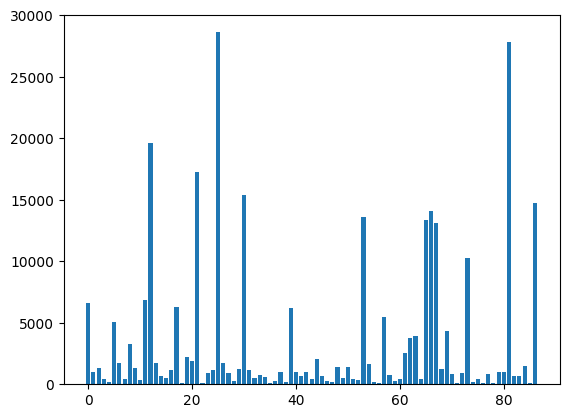

In [ ]:
row_count = original_df.sum()
plt.bar(range(original_df.shape[1]), row_count)